In [1]:
pip install transformers datasets torch scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Concatenate Features into a Single String
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Load Dataset
file_path = '/kaggle/input/new-datasets-final/final_datasets_new.csv'  # Adjust if needed
data = pd.read_csv(file_path)

# Fill Missing Data
data = data.fillna("unknown")  # Replace missing values with 'unknown'

# Concatenate Features into a Single String
def combine_features(row):
    return f"text: {row['text']} | detected_objects: {row['detected_objects']} | " \
           f"emotion: {row['Dominant Emotion']} | race: {row['Dominant Race']} | gender: {row['gender']} | " \
           f"age: {row['age']} | sentiment: {row['sentiment_analysis']}"

data['combined_features'] = data.apply(combine_features, axis=1)

# Select Relevant Columns
data = data[['combined_features', 'label']].dropna()  # Ensure no missing labels
data['label'] = data['label'].astype(int)

# Split Data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['combined_features'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42
)

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        # Return a dictionary with keys 'input_ids', 'attention_mask', and 'labels'
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create Datasets
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# Load Pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_steps=200,               # Log every 200 steps (can adjust based on your preference)
    logging_first_step=True,         # Log the first step as well
    report_to="none",                # Disable W&B logging (if you don't want to log to Weights & Biases)
    disable_tqdm=False,              # Ensure tqdm is enabled for progress bar
    load_best_model_at_end=True,     # Load the best model at the end of training (based on evaluation metric)
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
)

# Define the compute_metrics function
def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=1)  # Get the predicted classes (for classification tasks)
    
    # Calculate precision, recall, f1 score (for binary classification)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    
    # Calculate accuracy
    acc = accuracy_score(labels, preds)
    
    # Return the metrics as a dictionary
    return {
        "accuracy": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Use the compute_metrics function here
)

# Train the Model
trainer.train()

# Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead uns

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.634200,0.569551,0.710000,0.502523,0.705382,0.390282
2,0.553700,0.568508,0.712941,0.580756,0.642586,0.529781
3,0.495000,0.568831,0.712353,0.569163,0.649899,0.506270
4,0.420100,0.642080,0.692353,0.555650,0.606679,0.512539
5,0.334100,0.891297,0.679412,0.528954,0.589595,0.479624
6,0.258000,0.985678,0.671176,0.560189,0.562401,0.557994
7,0.189700,1.124713,0.678824,0.570079,0.572785,0.567398
8,0.149400,1.286059,0.671176,0.552442,0.564648,0.540752
9,0.101400,1.593326,0.680000,0.557724,0.579392,0.537618
10,0.080300,1.696857,0.676471,0.555735,0.573333,0.539185


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation Results: {'eval_loss': 0.5685080885887146, 'eval_accuracy': 0.7129411764705882, 'eval_f1': 0.5807560137457045, 'eval_precision': 0.6425855513307985, 'eval_recall': 0.5297805642633229, 'eval_runtime': 9.5568, 'eval_samples_per_second': 177.884, 'eval_steps_per_second': 5.65, 'epoch': 10.0}


In [8]:
# Save the model and tokenizer
trainer.save_model("./final_model")  # Specify the directory to save the model
tokenizer.save_pretrained("./final_model")

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


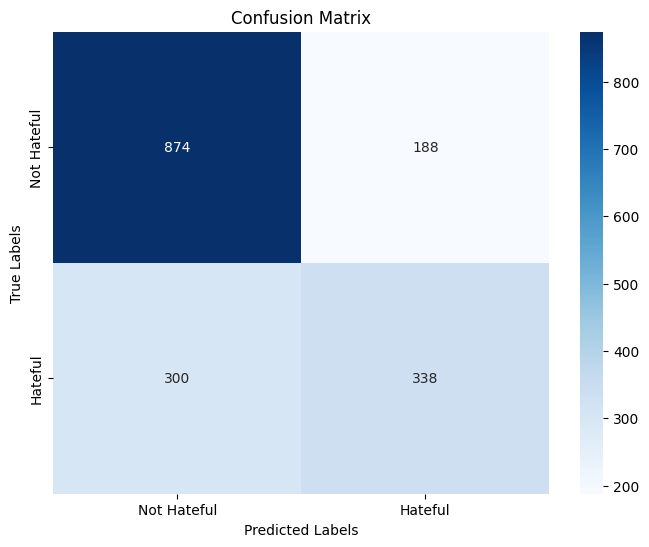

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# Predictions for Confusion Matrix
predictions = trainer.predict(val_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Hateful", "Hateful"], yticklabels=["Not Hateful", "Hateful"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [10]:
print(trainer.state.log_history)


[{'loss': 0.7631, 'grad_norm': 6.75515604019165, 'learning_rate': 1.0000000000000001e-07, 'epoch': 0.004694835680751174, 'step': 1}, {'loss': 0.6342, 'grad_norm': 5.638484954833984, 'learning_rate': 2e-05, 'epoch': 0.9389671361502347, 'step': 200}, {'eval_loss': 0.5695509314537048, 'eval_accuracy': 0.71, 'eval_f1': 0.5025227043390514, 'eval_precision': 0.7053824362606232, 'eval_recall': 0.390282131661442, 'eval_runtime': 9.8241, 'eval_samples_per_second': 173.043, 'eval_steps_per_second': 5.497, 'epoch': 1.0, 'step': 213}, {'loss': 0.5537, 'grad_norm': 2.8515050411224365, 'learning_rate': 4e-05, 'epoch': 1.8779342723004695, 'step': 400}, {'eval_loss': 0.5685080885887146, 'eval_accuracy': 0.7129411764705882, 'eval_f1': 0.5807560137457045, 'eval_precision': 0.6425855513307985, 'eval_recall': 0.5297805642633229, 'eval_runtime': 9.5098, 'eval_samples_per_second': 178.762, 'eval_steps_per_second': 5.678, 'epoch': 2.0, 'step': 426}, {'loss': 0.495, 'grad_norm': 4.905462265014648, 'learning_r